# Random Forest Algorithm and Its Application

This tutorial will give a brief introduction to random forest algorithm and an example of predicting max temperature based on random forest in python using `scikit-learn` library.

## Introduction to Random Forest

Random forest is a supervised learning algorithm that can be used both for classification and regression.

### Ensemble Methods

Generally, random forest is an ensemble of decision trees.  "The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator."[1] From the [documentation](http://scikit-learn.org/dev/modules/ensemble.html#forests-of-randomized-trees), `scikit-learn` library provides two kinds of ensemble methods: averaging methods and boosting methods with random forest falling into the former one.

### Decision Tree

Random forest takes advantage of decision tree as its base estimator. Basic concepts in decision tree will be briefly covered in this section.

Given a training set of data, decision tree algorithm will build a tree with each internal node indicating a decision rule for an attribute and each leaf node representing a result. An example of a decision tree is:
![Example of decision tree](decisionTree.png)
*(Image credit: www.packtpub.com )*

The prediction process in this decision tree will start from the root node with classification by the `salary` attribute. If the answer to the question on the root node is yes, the decision will move to next node with classification on `commuting time`. Then probably follows with attribute `coffee provided` until it moves to a leaf node, which represents a final decision.

A challenge in decision tree algorithm is about how to determine the attribute involved in each level, to make the decision tree more efficient and more accurate on later prediction. There are two main criterions for attribute evaluation: information gain and gini index. Those criterions assign a value for each attribute, followed by sorting attributes by values and putting them into the tree in order. The attribute with the highest value will be treated as the root node.

* **Information gain**: Information gain is mainly used when attributes are categorical. The concept of information gain is deducted from information theory that the value of attribute is determined by its entropy. An attribute with half of the data positive and remaining half negative has a high entropy, which results in a higher attribute value.

* **Gini index**: Gini index is mainly used when attributes are continuous. Gini index helps to measure how a randomly picked element will be incorrectly classified. An attribute with a lower gini index will have a higher value and locate in a node closer to root node.

More detailed description of decision tree algorithm as well as the implementation of those two attribute selection criterions can be found [here](https://dataaspirant.com/2017/01/30/how-decision-tree-algorithm-works/).

### Random Forest

With the knowledge of decision tree, we can step into random forest algorithm. A random forest is built by creating decision trees randomly. 

To generate a random forest, the algorithm randomly picks `k` attributes out of all attributes and creates a decision tree with those `k` attributes, then repeats the previous steps for `n` times to create `n` decision trees.

To predict the result for a new input vector, fit the input into every single decision tree in the forest. Then gather the outputs from all decision trees and return the result the one with the highest count among results returned by all trees in the forest, which is known as arboreal voting.

Since trees are built randomly, a large extent of those trees won't give meaningful path and results. However, the results given by non-meaningful trees will fall randomly into all of the choices, so they probably can cancel each other out.

**Feature Importance**

In addition to prediction result, random forest can also present the relative importance of features. As in `scikit-learn`, random forest will assign an importance score for each feature based on the number of tree nodes of this attributes that helps to reduce impurity. The importance scores of all attributes sum up to 1.

Since some of the features won't really relate to the result, from feature importance values, we can easily decide which features should be dropped to deal with overfitting problem. Thus, as a side product of random forest, feature importance scores can also be used in feature selection process in other learning methods.

### Motivations of using random forest

Random forest has several advantages in applications:

1. The same random forest algorithm can be used both for classification and regression.

2. Compared to a single decision tree, even we have a large amount of trees in the forest, random forest classifier won't overfit the model because each tree in the forest is built with a subset of the attributes and the result is generated by gathering results from all the trees.

3. With feature importance as part of the outcome, random forest can be also used to identify the most relavant attributes from all of the attributes, which is a reliable feature selection method.

4. Random forest is able to handle missing values. Random forest algorithm actually provide two ways of replacing missing values, detailed information can be found [here](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#missing1).

Random forest algorithm has many real life applications in different fields like banking, finance, medicine etc. For example, in banking area, one of the classification problem is to detect whether a customer is a fraud customer. Similarly, random forest can be also used to find well-bahaved customer. In addition, random forest can be used in regression problems, like in the following example of predicting max temperature of a certain day.

## Example: Max Temperature Prediction based on Random Forest

In the following sections, an example of random forest application will be shown. The problem here is to predict the max temperature of a day in San Francisco with the daily temperature data (including max temperature, min temperature, average temperature) of 1 and 2 days prior, as well as the max temperature last year. This is a fairly simple regression problem that can help to give a sense of the whole process to solve regression problem with random forest algorithm. This example is inspired from [here](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0).

### Import Libraries

Here includes the libraries needed to do data processing, random forest algorithm and visualization. 
Note if you haven't installed [pydot](https://anaconda.org/anaconda/pydot) before, run `conda install pydot graphviz` in command line to install it.

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.tree import export_graphviz
# conda install pydot graphviz
import pydot

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [10,4]

### Data analysis and preprocessing

The temperature data used in this example is downloaded from [NOAA Climate Data Online](https://www.ncdc.noaa.gov/cdo-web/). From the website we can search for daily summaries in San Francisco from 2016-12-30 to 2017-12-31 (those two days in 2016 is for 2 days prior information) and download a well-formatted csv file. 

Let's have a quick look on the raw data. Each row in the table represents the daily information collected from one climate station, including the station information ( `STATION`, `NAME`, `LATITUDE`, `LONGITUDE`, `ELEVATION` ) and the temperature ( `TAVG`, `TMAX`, `TMIN` ).

In [2]:
raw_data_2017 = pd.read_csv('sfo2017.csv')
raw_data_2017.head(5)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,TAVG,TMAX,TMIN,TOBS
0,USR0000CSVA,"SPRING VALLEY CALIFORNIA, CA US",37.5625,-122.4364,327.7,2016-12-30,51.0,60.0,45.0,NaN
1,USR0000CSVA,"SPRING VALLEY CALIFORNIA, CA US",37.5625,-122.4364,327.7,2016-12-31,44.0,49.0,40.0,NaN
2,USR0000CSVA,"SPRING VALLEY CALIFORNIA, CA US",37.5625,-122.4364,327.7,2017-01-01,44.0,49.0,41.0,NaN
3,USR0000CSVA,"SPRING VALLEY CALIFORNIA, CA US",37.5625,-122.4364,327.7,2017-01-02,43.0,46.0,40.0,NaN
4,USR0000CSVA,"SPRING VALLEY CALIFORNIA, CA US",37.5625,-122.4364,327.7,2017-01-03,49.0,53.0,44.0,NaN


In [3]:
num_stations = len(raw_data_2017.STATION.unique())
print('The daily climate summaries in San Francisco is collected from', num_stations, 'stations')

The daily climate summaries in San Francisco is collected from 32 stations


In the max temperature prediction, several attributes are needed, including the max temperature last year (2016), the max / avg / min temperature of 2 days prior, and the max / avg / min temperature of 1 day prior.

Thus a csv file including daily summaries in 2016 is downloaded from NOAA as well, in order to get the daily max temperature of previous year. To match the max temperature into year 2017 data, we can calculate the number of total records as a simple way to check if there're any missing data. Additionally, since 2016 is a leap year, the daily summary for Feb 29 is removed from the data list.

In [4]:
raw_data_2016 = pd.read_csv('sfo2016.csv')

date_2016 = list(raw_data_2016.groupby('DATE').groups.keys())
print('# of total records in 2016:', len(date_2016))

# Max temperature in 2016
max_column_2016 = raw_data_2016.groupby('DATE').TMAX.max()
max_column_2016 = max_column_2016.drop('2016-02-29')
print('# of records after dropping the extra day:', len(max_column_2016))

# of total records in 2016: 366
# of records after dropping the extra day: 365


Temperature data of 2 days prior and 1 day prior are generated from the 2017 dataset.

In [5]:
date = list(raw_data_2017.groupby('DATE').groups.keys())[2:]
print('# of records in 2017:', len(date))

dt_array = [datetime.strptime(s, '%Y-%m-%d') for s in date]
day = [dt.day for dt in dt_array]
month = [dt.month for dt in dt_array]
weekday = [dt.weekday() for dt in dt_array]

max_column = raw_data_2017.groupby('DATE').TMAX.max()

# The max temperature of 2 days prior
max_2 = max_column.iloc[:-2]

# The max temperature of 1 day prior
max_1 = max_column.iloc[1:-1]

# Previous min temperature
min_column = raw_data_2017.groupby('DATE').TMIN.min()
min_2 = min_column.iloc[:-2]
min_1 = min_column.iloc[1:-1]

# Previous avg temperature
avg_column = raw_data_2017.groupby('DATE').TAVG.mean()
avg_2 = avg_column.iloc[:-2]
avg_1 = avg_column.iloc[1:-1]

# All attributes
data = {'month': np.array(month), 
        'day': np.array(day), 
        'weekday': np.array(weekday),
        'his_max': np.array(max_column_2016), 
        'max_2': np.array(max_2), 
        'max_1': np.array(max_1), 
        'min_2': np.array(min_2),
        'min_1': np.array(min_1),
        'avg_2': np.array(avg_2),
        'avg_1': np.array(avg_1)
       }
attributes_data = pd.DataFrame(data)

attributes_names = list(attributes_data.columns)
print('Attributes include: ', attributes_names)

# Ground truth of max temperature
actual_max = np.array(max_column.iloc[2:])

attributes_data.head()

# of records in 2017: 365
Attributes include:  ['avg_1', 'avg_2', 'day', 'his_max', 'max_1', 'max_2', 'min_1', 'min_2', 'month', 'weekday']


,avg_1,avg_2,day,his_max,max_1,max_2,min_1,min_2,month,weekday
0,44.583333,50.000000,1,57.0,61.0,64.0,30.0,30.0,1,6
1,45.000000,44.583333,2,57.0,58.0,61.0,34.0,30.0,1,0
2,43.166667,45.000000,3,62.0,55.0,58.0,33.0,34.0,1,1
3,47.583333,43.166667,4,62.0,59.0,55.0,34.0,33.0,1,2
4,49.166667,47.583333,5,60.0,59.0,59.0,39.0,34.0,1,3


The attributes in `attributes_data` table are:

* **month**: month
* **day**: day in month
* **weekday**: weekday
* **his_max**: the max temperature of this date in previous year (2016)
* **max_2**: the max temperature of 2 days prior
* **max_1**: the max temperature of 1 day prior
* **min_2**: the min temperature of 2 days prior
* **min_1**: the min temperature of 1 day prior
* **avg_2**: the average temperature of 2 days prior
* **avg_1**: the average temperature of 1 day prior

And the ground truth of actual max temperature is stored in `actual_max` list.

Also we can have a general idea of all data from `describe` the dataframe.

In [6]:
attributes_data.describe()

,avg_1,avg_2,day,his_max,max_1,max_2,min_1,min_2,month,weekday
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,58.859782,58.858728,15.720548,78.756164,78.915068,78.893151,41.156164,41.153425,6.526027,3.008219
std,9.276980,9.277967,8.808321,12.156410,13.265916,13.283969,7.346992,7.350975,3.452584,2.006155
min,38.307692,38.307692,1.000000,56.000000,54.000000,54.000000,20.000000,20.000000,1.000000,0.000000
25%,52.250000,52.250000,8.000000,70.000000,68.000000,68.000000,36.000000,36.000000,4.000000,1.000000
50%,57.166667,57.166667,16.000000,78.000000,78.000000,78.000000,42.000000,42.000000,7.000000,3.000000
75%,64.230769,64.230769,23.000000,88.000000,89.000000,89.000000,46.000000,46.000000,10.000000,5.000000
max,92.307692,92.307692,31.000000,108.000000,113.000000,113.000000,60.000000,60.000000,12.000000,6.000000


### Training and testing sets split

Then randomly split the whole dataset into training set and testing set with `train_test_split` function, with testing set contains around 30% of the whole records.

In [7]:
features = np.array(attributes_data)
train_features, test_features, train_results, test_results = train_test_split(features, actual_max, test_size = 0.3, random_state=5)

In [8]:
print('Training Features:', train_features.shape)
print('Test Features:', test_features.shape)

Training Features: (255, 10)
Test Features: (110, 10)


### Random forest training

We will build a random forest with support from `scikit-learn` library. From `scikit-learn` documentation, the main parameters when using random forest regressor are `n_estimators` and `max_features`. 

* `n_estimators`: represents the number of trees that will be generated in the forest. The more trees will result in more accuracy, but in lower speed. 
* `max_features`: defines the max number of features in one simple tree.

Description for other parameters can be found in the [documentation](http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor).

**Hyperparameter Tuning**

`GridSearchCV` can help to find out the best parameter used in the random forest model. The next code snippet defines possible parameters for a `RandomForestRegressor`, and get the best parameters from `GridSearchCV`. To make sure the random process in building a random forest doesn't affect the best paramter searching, we should define the `random_state` as the seed used by random number generator. Hyperparameter tuning process will take a relatively long time.

In [9]:
param_grid = {"n_estimators": [100, 400, 700, 1000, 1500, 2000], 
              "max_features": ["auto", "sqrt"]}

rf = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, n_jobs=-1, random_state=1)

clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
clf.fit(train_features, train_results)

max_features = clf.best_params_['max_features']
n_estimators = clf.best_params_['n_estimators']

clf.best_params_

{'max_features': 'sqrt', 'n_estimators': 1500}

**Training**

Create a random forest regressor with the parameters above.

In [10]:
rf = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, oob_score=True, n_jobs=-1, random_state=1)
rf.fit(train_features, train_results)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=-1,
           oob_score=True, random_state=1, verbose=0, warm_start=False)

### Prediction and result analysis

Predict the max temperature based on the model defined above.

In [11]:
predictions = rf.predict(test_features)

Define 2 baseline data for comparison. 

1. Predict from the max temperature in 2016: max temperature would be the max temperature today of 2016 ±5 degree
2. Predict from the max temperature of 1 day prior: max temperature would be the max temperature yesterday ±5 degree

We can calculate the average error of prediction from random forest algorithm and those two baseline methods.

Average absolute error of random forest (degree): 3.2946969697
Average absolute error of prediction from his_max (degree): 8.09090909091
Average absolute error of prediction from max_1 (degree): 3.74545454545


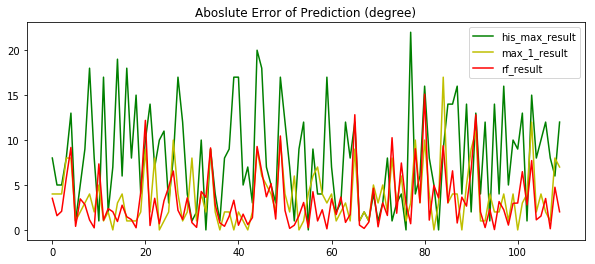

In [12]:
errors = abs(predictions - test_results)

# Baseline: predict max temperature from 2016 daily summaries
test_his_max = test_features[:, 3] + randint(-5, 5)
errors_baseline_his_max = abs(test_his_max - test_results)

# Baseline: predict max temperature from the max temperature of 1 day prior
test_max_1 = test_features[:, 4] + randint(-5, 5)
errors_baseline_max_1 = abs(test_max_1 - test_results)

print('Average absolute error of random forest (degree):', np.mean(errors))
print('Average absolute error of prediction from his_max (degree):',np.mean(errors_baseline_his_max))
print('Average absolute error of prediction from max_1 (degree):',np.mean(errors_baseline_max_1))

plt.plot(errors_baseline_his_max, 'g', label='his_max_result')
plt.plot(errors_baseline_max_1, 'y', label='max_1_result')
plt.plot(errors, 'r', label='rf_result')
plt.title('Aboslute Error of Prediction (degree)')
plt.legend()
plt.show()

Average accuracy of prediction with random forest algorithm can also be calculated.

In [13]:
scores = 1 - errors / test_results
print('Average accuracy from random forest regressor:', np.round(scores.mean() * 100, 2), '%')

Average accuracy from random forest regressor: 95.86 %


As can be seen above, random forest algorithm reaches a high accuracy on prediction of max temperature, and its absolute errors on temperatures are lower compared to those two baselines. Though the prediction from max temperature of 1 day prior also reaches a relatively low absolute error in degree, the errors of results from random forest are always lower still.

### Visualization on one of the tree in forest

`scikit-learn` library provides way to access the decision trees in the forest. Below is the visualization of the tree with index 1 in the forest. It's a very broad tree actually. You can directly open `tree.png` to see the details in it if interested.

In [14]:
tree_index = 1
decision_tree = rf.estimators_[tree_index]
export_graphviz(decision_tree, out_file = 'tree.dot', feature_names = attributes_names, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

![tree](tree.png)

### Feature Importance

An additional feature that random forest provides is the feature importance values. From feature importance values, we can have an idea of which attributes are more relative to give a prediction.

In [15]:
importances = pd.DataFrame({'feature': attributes_names, 'importance': np.round(rf.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending = False).set_index('feature')
importances

,importance
feature,
max_1,0.292
avg_1,0.256
max_2,0.162
avg_2,0.128
his_max,0.064
min_1,0.028
min_2,0.025
month,0.025
day,0.014


From the above table, we can see the max temperature of 1 day prior affects the prediction most. This result also explains why the absolute errors of prediction from max temperature of 1 day prior is relatively small than the other baseline.

The importance of attributes are visualized below.

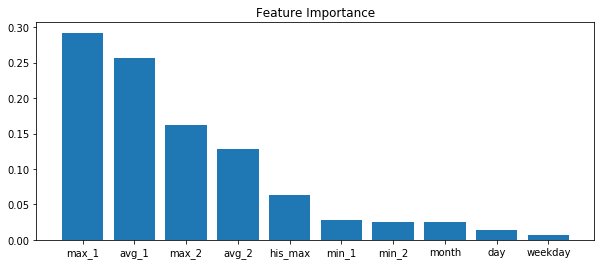

In [16]:
x = np.arange(len(importances.index))
plt.bar(x, height=importances.importance, align='center')
plt.title('Feature Importance')
plt.xticks(x, importances.index)
plt.show()

Some of the attributes are comparably irrelevant, like `min_1`, `month`, `min_2` etc. We can assume that dropping those attributes won't hurt on the prediction. Here drop two columns `min_1` and `min_2` and train the random forest again.

In [17]:
# Drop min_1 and min_2 from attributes
train_features = np.delete(train_features, np.s_[6:7], axis=1)
test_features = np.delete(test_features, np.s_[6:7], axis=1)

rf = RandomForestRegressor(n_estimators=700, max_features='sqrt', oob_score=True, n_jobs=-1, random_state=1)
rf.fit(train_features, train_results)

predictions = rf.predict(test_features)
errors = abs(predictions - test_results)
print('Average absolute error of random forest (degree):', np.mean(errors))
scores = 1 - errors / test_results
print('Average accuracy from random forest regressor:', np.round(scores.mean() * 100, 2), '%')

Average absolute error of random forest (degree): 3.34880519481
Average accuracy from random forest regressor: 95.8 %


According to the results from new random forest, the accuracy doesn't drop after removing two attributes from the dataset. Thus, feature importance values are good references for other learning methods to prevent overfitting.

## Conclusion

Random forest is a learning method useful in classification and regression problems. It has advantages like avoiding overfitting, able to deal with missing data and relatively fast and simple to use. There can be a lot of applications based on random forest in different fields including banking and e-commerce.

In the example above, random forest algorithm gives a decent result on predicting max temperatures. And from feature importance values, we can easily tell the max temperature of 1 day prior affects the prediction most, as well as that some attributes like min temperatures are not as relevant.

## References

[1] Ensemble Methods http://scikit-learn.org/dev/modules/ensemble.html#forests-of-randomized-trees

[2] How decision tree algorithm works https://dataaspirant.com/2017/01/30/how-decision-tree-algorithm-works/ 

[3] How the random forest algorithm works in machine learning http://dataaspirant.com/2017/05/22/random-forest-algorithm-machine-learing/

[4] Random Forests in Python https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

[5] End to End Project with Python https://www.kaggle.com/niklasdonges/end-to-end-project-with-python